# Blockchain-Enhanced Privacy & Security in IoT-Based Smart Traffic Management


This notebook implements an end-to-end secure and privacy-preserving IoT-based smart traffic management system using a real-world dataset (Metro Interstate Traffic Volume). It includes:

- Real traffic data ingestion and preprocessing
- Congestion prediction using machine learning (Random Forest + Logistic Regression)
- Use of weather features and feature importance analysis
- Time-series visualization of traffic volume
- AES-256-GCM encryption for traffic records
- Blockchain-style logging with SHA-256 for tamper evidence
- Role-Based Access Control (RBAC) with unauthorized access logging
- Performance comparison: plaintext vs secure pipeline
- Encryption/decryption latency measurement
- Simple Proof-of-Work simulation
- Multi-sensor IoT scenario simulation
- Export of encrypted store to JSON


In [1]:
import os
import json
import time
from dataclasses import dataclass, asdict
from typing import Dict, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cryptography.hazmat.primitives.ciphers.aead import AESGCM
import hashlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Metro_Interstate_Traffic_Volume.csv to Metro_Interstate_Traffic_Volume.csv


In [3]:
filename = list(uploaded.keys())[0]

df_raw = pd.read_csv(filename)
print("Loaded file:", filename)
print("Raw shape:", df_raw.shape)
df_raw.head()

Loaded file: Metro_Interstate_Traffic_Volume.csv
Raw shape: (48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
traffic_df = pd.DataFrame()

# Core columns
traffic_df["timestamp"]   = pd.to_datetime(df_raw["date_time"])
traffic_df["junction_id"] = "J1"           # one highway segment
traffic_df["sensor_id"]   = "S1"
traffic_df["vehicle_count"] = df_raw["traffic_volume"]

# Derived average speed (synthetic but monotonic)
max_speed = 80  # km/h
traffic_df["avg_speed"] = np.maximum(
    5, max_speed - traffic_df["vehicle_count"] / 200.0
).round(2)

# Attach weather numeric features
traffic_df["temp"]      = df_raw["temp"]
traffic_df["rain_1h"]   = df_raw["rain_1h"].fillna(0)
traffic_df["snow_1h"]   = df_raw["snow_1h"].fillna(0)
traffic_df["clouds_all"] = df_raw["clouds_all"].fillna(df_raw["clouds_all"].mean())

# Congestion levels
def label_congestion(v):
    if v > 5500:
        return "HIGH"
    elif v > 3000:
        return "MEDIUM"
    else:
        return "LOW"

traffic_df["congestion_level"] = traffic_df["vehicle_count"].apply(label_congestion)

# Binary target for ML
traffic_df["is_congested"] = traffic_df["congestion_level"].map(
    lambda x: 1 if x in ["MEDIUM", "HIGH"] else 0
)

print("Cleaned traffic_df shape:", traffic_df.shape)
traffic_df.head()


Cleaned traffic_df shape: (48204, 11)


,timestamp,junction_id,sensor_id,vehicle_count,avg_speed,temp,rain_1h,snow_1h,clouds_all,congestion_level,is_congested
0,2012-10-02 09:00:00,J1,S1,5545,52.28,288.28,0.0,0.0,40,HIGH,1
1,2012-10-02 10:00:00,J1,S1,4516,57.42,289.36,0.0,0.0,75,MEDIUM,1
2,2012-10-02 11:00:00,J1,S1,4767,56.16,289.58,0.0,0.0,90,MEDIUM,1
3,2012-10-02 12:00:00,J1,S1,5026,54.87,290.13,0.0,0.0,90,MEDIUM,1
4,2012-10-02 13:00:00,J1,S1,4918,55.41,291.14,0.0,0.0,75,MEDIUM,1


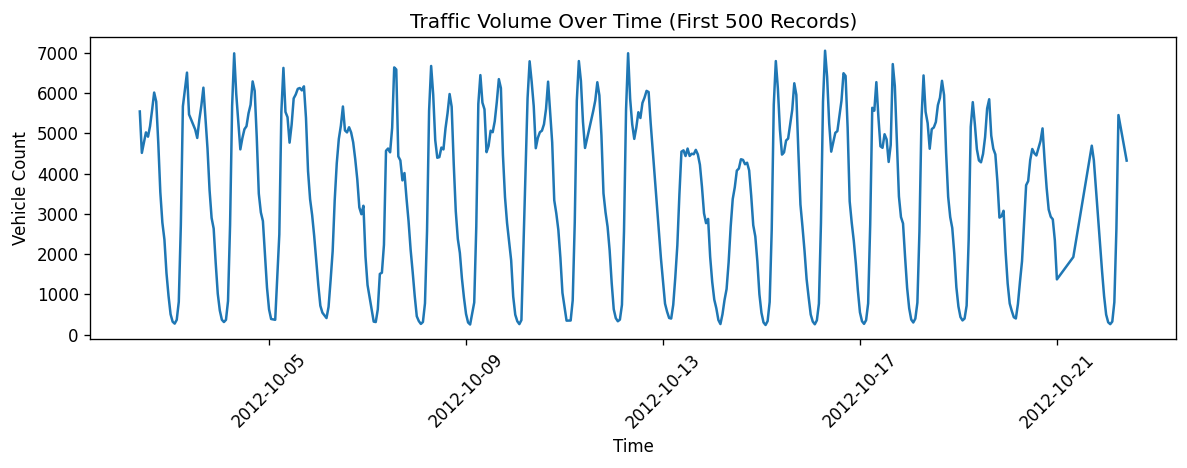

In [5]:
sample_series = traffic_df.sort_values("timestamp").head(500)

plt.figure(figsize=(10, 4))
plt.plot(sample_series["timestamp"], sample_series["vehicle_count"])
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Vehicle Count")
plt.title("Traffic Volume Over Time (First 500 Records)")
plt.tight_layout()
plt.show()


In [6]:
feature_cols = [
    "vehicle_count",
    "avg_speed",
    "temp",
    "rain_1h",
    "snow_1h",
    "clouds_all"
]

X = traffic_df[feature_cols]
y = traffic_df["is_congested"]

print("Class distribution (0=LOW, 1=MED/HIGH):")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

rf_clf = RandomForestClassifier(
    n_estimators=150,
    random_state=42
)
rf_clf.fit(X_train_scaled, y_train)

y_pred  = rf_clf.predict(X_test_scaled)
y_proba = rf_clf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("=== Random Forest (with weather features) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")


Class distribution (0=LOW, 1=MED/HIGH):
is_congested
1    26680
0    21524
Name: count, dtype: int64
=== Random Forest (with weather features) ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC-AUC  : 1.0000


Confusion Matrix:
[[6458    0]
 [   0 8004]]


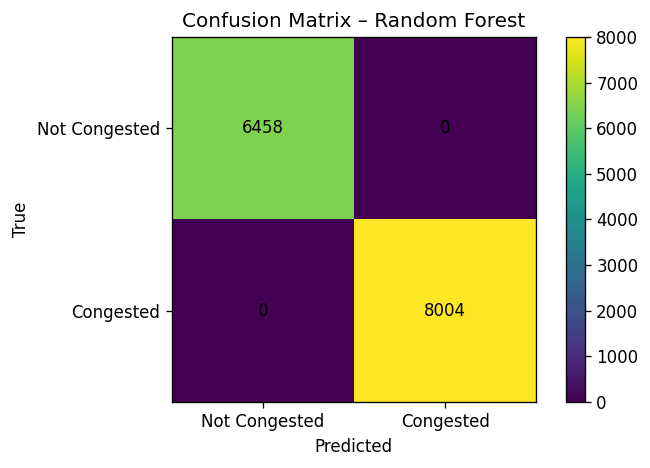

In [7]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xticks([0, 1], ["Not Congested", "Congested"])
plt.yticks([0, 1], ["Not Congested", "Congested"])
plt.colorbar()
plt.tight_layout()
plt.show()

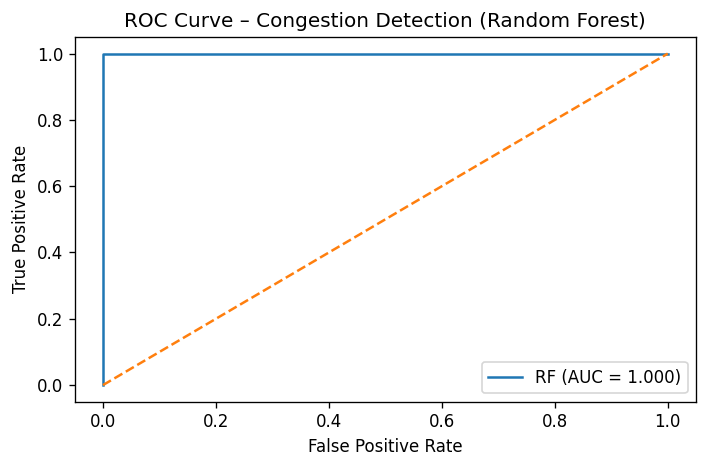

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"RF (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Congestion Detection (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

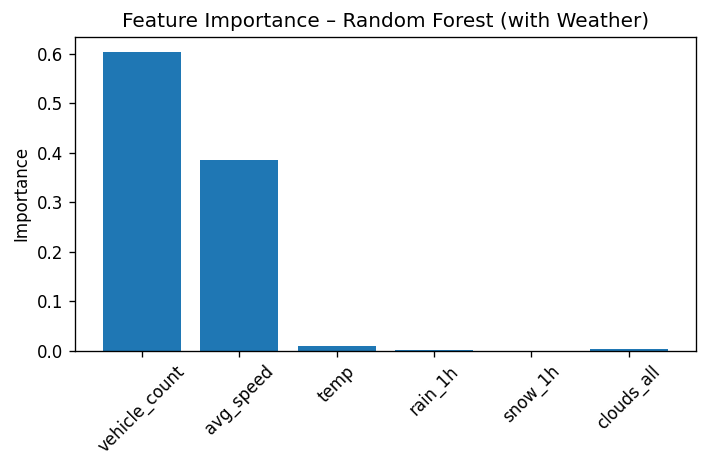

vehicle_count : 0.6033
avg_speed    : 0.3843
temp         : 0.0088
clouds_all   : 0.0035
rain_1h      : 0.0001
snow_1h      : 0.0000


In [9]:
importances = rf_clf.feature_importances_

plt.figure()
plt.bar(feature_cols, importances)
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.title("Feature Importance – Random Forest (with Weather)")
plt.tight_layout()
plt.show()

for feat, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{feat:12s} : {imp:.4f}")

In [10]:
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

scaler_log = StandardScaler()
X_log_train_scaled = scaler_log.fit_transform(X_log_train)
X_log_test_scaled  = scaler_log.transform(X_log_test)

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_log_train_scaled, y_log_train)

y_log_pred  = log_clf.predict(X_log_test_scaled)
y_log_proba = log_clf.predict_proba(X_log_test_scaled)[:, 1]

acc_log = accuracy_score(y_log_test, y_log_pred)
prec_log = precision_score(y_log_test, y_log_pred)
rec_log  = recall_score(y_log_test, y_log_pred)
f1_log   = f1_score(y_log_test, y_log_pred)
auc_log  = roc_auc_score(y_log_test, y_log_proba)

print("=== Logistic Regression (with weather features) ===")
print(f"Accuracy : {acc_log:.4f}")
print(f"Precision: {prec_log:.4f}")
print(f"Recall   : {rec_log:.4f}")
print(f"F1-score : {f1_log:.4f}")
print(f"ROC-AUC  : {auc_log:.4f}")

print("\n=== RF vs Logistic ROC-AUC ===")
print(f"Random Forest ROC-AUC : {auc:.4f}")
print(f"Logistic ROC-AUC      : {auc_log:.4f}")


=== Logistic Regression (with weather features) ===
Accuracy : 0.9983
Precision: 0.9990
Recall   : 0.9980
F1-score : 0.9985
ROC-AUC  : 0.9999

=== RF vs Logistic ROC-AUC ===
Random Forest ROC-AUC : 1.0000
Logistic ROC-AUC      : 0.9999


In [11]:
AES_KEY = AESGCM.generate_key(bit_length=256)
aesgcm = AESGCM(AES_KEY)

def encrypt_record(record: Dict[str, Any], aad: bytes = None):
    plaintext = json.dumps(record, default=str).encode("utf-8")
    nonce = os.urandom(12)
    ciphertext = aesgcm.encrypt(nonce, plaintext, aad)
    return nonce, ciphertext

def decrypt_record(nonce: bytes, ciphertext: bytes, aad: bytes = None):
    plaintext = aesgcm.decrypt(nonce, ciphertext, aad)
    return json.loads(plaintext.decode("utf-8"))

# Check correctness
sample = traffic_df.iloc[0].to_dict()
n, c = encrypt_record(sample)
dec = decrypt_record(n, c)
print("Original:", sample)
print("Decrypted:", dec)


Original: {'timestamp': Timestamp('2012-10-02 09:00:00'), 'junction_id': 'J1', 'sensor_id': 'S1', 'vehicle_count': 5545, 'avg_speed': 52.28, 'temp': 288.28, 'rain_1h': 0.0, 'snow_1h': 0.0, 'clouds_all': 40, 'congestion_level': 'HIGH', 'is_congested': 1}
Decrypted: {'timestamp': '2012-10-02 09:00:00', 'junction_id': 'J1', 'sensor_id': 'S1', 'vehicle_count': 5545, 'avg_speed': 52.28, 'temp': 288.28, 'rain_1h': 0.0, 'snow_1h': 0.0, 'clouds_all': 40, 'congestion_level': 'HIGH', 'is_congested': 1}


In [12]:
@dataclass
class Block:
    index: int
    timestamp: float
    data_hash: str
    device_id: str
    junction_id: str
    prev_hash: str

    def compute_block_hash(self) -> str:
        block_str = json.dumps(asdict(self), sort_keys=True).encode("utf-8")
        return hashlib.sha256(block_str).hexdigest()


class SimpleBlockchain:
    def __init__(self):
        self.chain: List[Block] = []
        self.create_genesis_block()

    def create_genesis_block(self):
        genesis = Block(
            index=0,
            timestamp=time.time(),
            data_hash="GENESIS",
            device_id="GENESIS",
            junction_id="NONE",
            prev_hash="0" * 64
        )
        self.chain.append(genesis)

    @property
    def last_block(self) -> Block:
        return self.chain[-1]

    def add_block(self, data_hash: str, device_id: str, junction_id: str) -> Block:
        new_block = Block(
            index=len(self.chain),
            timestamp=time.time(),
            data_hash=data_hash,
            device_id=device_id,
            junction_id=junction_id,
            prev_hash=self.last_block.compute_block_hash()
        )
        self.chain.append(new_block)
        return new_block

    def is_valid(self) -> bool:
        for i in range(1, len(self.chain)):
            prev = self.chain[i - 1]
            curr = self.chain[i]
            if curr.prev_hash != prev.compute_block_hash():
                return False
        return True

blockchain = SimpleBlockchain()
print("Initial chain length:", len(blockchain.chain))
print("Is chain valid?:", blockchain.is_valid())


Initial chain length: 1
Is chain valid?: True


In [13]:
class AccessControl:
    def __init__(self):
        self.roles: Dict[str, str] = {}

    def add_user(self, entity_id: str, role: str):
        self.roles[entity_id] = role

    def has_role(self, entity_id: str, required_role: str) -> bool:
        return self.roles.get(entity_id) == required_role

    def require_role(self, entity_id: str, required_role: str):
        if not self.has_role(entity_id, required_role):
            raise PermissionError(
                f"Entity '{entity_id}' does not have required role '{required_role}'"
            )

access_control = AccessControl()
access_control.add_user("traffic_authority", "AUTHORITY")
access_control.add_user("researcher_1", "RESEARCHER")

access_log = []

def log_violation(entity_id: str, block_index: int, reason: str):
    access_log.append({
        "entity": entity_id,
        "block_index": block_index,
        "reason": reason,
        "timestamp": time.time()
    })

access_control.roles


{'traffic_authority': 'AUTHORITY', 'researcher_1': 'RESEARCHER'}

In [14]:
encrypted_store: Dict[int, Dict[str, Any]] = {}

def sha256_bytes(data: bytes) -> str:
    return hashlib.sha256(data).hexdigest()

def ingest_record(record: Dict[str, Any], device_id: str):
    nonce, ciphertext = encrypt_record(record)
    data_hash = sha256_bytes(ciphertext)

    block = blockchain.add_block(
        data_hash=data_hash,
        device_id=device_id,
        junction_id=record["junction_id"]
    )

    encrypted_store[block.index] = {
        "nonce": nonce,
        "ciphertext": ciphertext
    }
    return block

# Ingest ~200 records for demo (not entire dataset)
blockchain = SimpleBlockchain()
encrypted_store = {}

step = max(1, len(traffic_df) // 200)
print("Ingest step:", step)

for i in range(0, len(traffic_df), step):
    rec = traffic_df.iloc[i].to_dict()
    ingest_record(rec, device_id=f"sensor_{rec['junction_id']}")

print("Blocks in chain:", len(blockchain.chain))
print("Encrypted entries:", len(encrypted_store))
print("Chain valid?:", blockchain.is_valid())


Ingest step: 241
Blocks in chain: 202
Encrypted entries: 201
Chain valid?: True


In [15]:
def verify_block(block_index: int) -> bool:
    if block_index == 0:
        return True  # genesis

    if block_index not in encrypted_store:
        return False

    block = blockchain.chain[block_index]
    entry = encrypted_store[block_index]
    ciphertext = entry["ciphertext"]
    current_hash = sha256_bytes(ciphertext)

    return current_hash == block.data_hash

# Check first few blocks BEFORE tampering
integrity_before = {b.index: verify_block(b.index) for b in blockchain.chain}
list(integrity_before.items())[:5]


[(0, True), (1, True), (2, True), (3, True), (4, True)]

In [16]:
target_index = 1 if len(blockchain.chain) > 1 else 0
print("Tampering block index:", target_index)
print("Before tampering:", verify_block(target_index))

entry = encrypted_store[target_index]
tampered_ciphertext = bytearray(entry["ciphertext"])
if len(tampered_ciphertext) > 0:
    tampered_ciphertext[0] ^= 0xFF
entry["ciphertext"] = bytes(tampered_ciphertext)

print("After tampering:", verify_block(target_index))


Tampering block index: 1
Before tampering: True
After tampering: False


In [17]:
def read_and_decrypt(block_index: int, entity_id: str, required_role: str = "AUTHORITY"):
    try:
        access_control.require_role(entity_id, required_role)
    except PermissionError as e:
        log_violation(entity_id, block_index, str(e))
        raise

    if block_index not in encrypted_store:
        raise ValueError("No encrypted data for this block index")

    entry = encrypted_store[block_index]
    nonce = entry["nonce"]
    ciphertext = entry["ciphertext"]
    record = decrypt_record(nonce, ciphertext)
    return record

print("Authorized read:")
try:
    rec_auth = read_and_decrypt(1, "traffic_authority")
    print(rec_auth)
except Exception as e:
    print("Error:", e)

print("\nUnauthorized read:")
try:
    rec_unauth = read_and_decrypt(1, "researcher_1")
    print("Should not see:", rec_unauth)
except Exception as e:
    print("Unauthorized blocked:", e)

print("\nAccess log entries:")
access_log


Authorized read:
Error: 

Unauthorized read:
Unauthorized blocked: Entity 'researcher_1' does not have required role 'AUTHORITY'

Access log entries:


[{'entity': 'researcher_1',
  'block_index': 1,
  'reason': "Entity 'researcher_1' does not have required role 'AUTHORITY'",
  'timestamp': 1764627680.458067}]

In [18]:
t_enc = []
t_dec = []
num_trials = 100

for i in range(num_trials):
    rec = traffic_df.sample(1).iloc[0].to_dict()

    start = time.perf_counter()
    nonce, ciphertext = encrypt_record(rec)
    t_enc.append(time.perf_counter() - start)

    start = time.perf_counter()
    _ = decrypt_record(nonce, ciphertext)
    t_dec.append(time.perf_counter() - start)

print(f"Trials: {num_trials}")
print(f"Average encryption time  (s): {np.mean(t_enc):.8f}")
print(f"Average decryption time  (s): {np.mean(t_dec):.8f}")
print(f"Max encryption time      (s): {np.max(t_enc):.8f}")
print(f"Max decryption time      (s): {np.max(t_dec):.8f}")


Trials: 100
Average encryption time  (s): 0.00011455
Average decryption time  (s): 0.00005083
Max encryption time      (s): 0.00118303
Max decryption time      (s): 0.00099971


Plain time (s):  0.24225386699998808
Secure time (s): 0.5966818919999923
Overhead factor: 2.4630438283159446


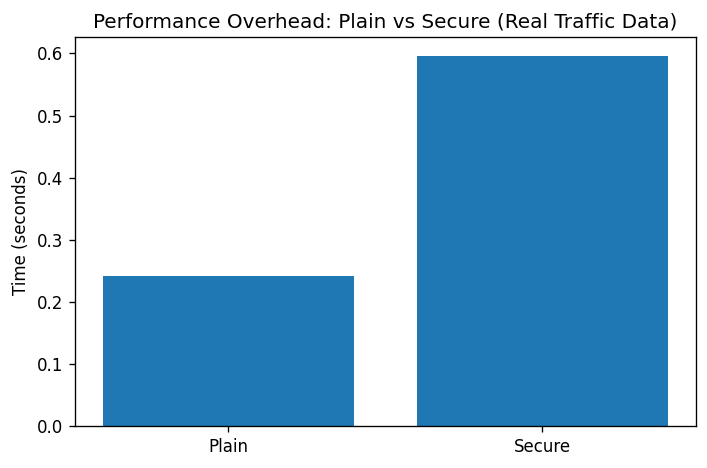

In [19]:
def baseline_store(records: pd.DataFrame):
    storage = []
    t0 = time.perf_counter()
    for _, row in records.iterrows():
        storage.append(row.to_dict())
    t1 = time.perf_counter()
    return storage, t1 - t0

def secure_store(records: pd.DataFrame):
    bc = SimpleBlockchain()
    store = {}
    t0 = time.perf_counter()
    for _, row in records.iterrows():
        rec = row.to_dict()
        nonce, ciphertext = encrypt_record(rec)
        data_hash = sha256_bytes(ciphertext)
        block = bc.add_block(
            data_hash=data_hash,
            device_id=f"sensor_{rec['junction_id']}",
            junction_id=rec["junction_id"]
        )
        store[block.index] = {"nonce": nonce, "ciphertext": ciphertext}
    t1 = time.perf_counter()
    return bc, store, t1 - t0

n_samples = min(2000, len(traffic_df))
subset = traffic_df.sample(n=n_samples, random_state=42)

plain_store, t_plain = baseline_store(subset)
bc_secure, secure_store_dict, t_secure = secure_store(subset)

print("Plain time (s): ", t_plain)
print("Secure time (s):", t_secure)
print("Overhead factor:", t_secure / t_plain if t_plain > 0 else None)

methods = ["Plain", "Secure"]
times = [t_plain, t_secure]

plt.figure()
plt.bar(methods, times)
plt.ylabel("Time (seconds)")
plt.title("Performance Overhead: Plain vs Secure (Real Traffic Data)")
plt.tight_layout()
plt.show()


In [20]:
print("Index | prev_hash[0:12] -> data_hash[0:12]")
for block in blockchain.chain[:8]:
    print(f"{block.index:5d} | {block.prev_hash[:12]} -> {block.data_hash[:12]}")


Index | prev_hash[0:12] -> data_hash[0:12]
    0 | 000000000000 -> GENESIS
    1 | 578be6a14a56 -> 440a39429325
    2 | c62d8e5b6e41 -> aa2897e1ea07
    3 | 00ac34d8c22e -> fd31dea30fe4
    4 | 6fb64f4190c2 -> a0e481970e27
    5 | 26c336331566 -> d9c172bba920
    6 | 3fdc033e9a2a -> f6b6db428892
    7 | 0ebda3d148e7 -> a00811a370bb


In [21]:
def proof_of_work(data_hash: str, difficulty: int = 3):
    prefix = "0" * difficulty
    nonce = 0
    while True:
        attempt = data_hash + str(nonce)
        guess = hashlib.sha256(attempt.encode()).hexdigest()
        if guess.startswith(prefix):
            return nonce, guess
        nonce += 1

if len(blockchain.chain) > 1:
    target_block = blockchain.chain[1]
    print("Running PoW on block index:", target_block.index)
    print("Original data_hash:", target_block.data_hash)
    nonce, pow_hash = proof_of_work(target_block.data_hash, difficulty=3)
    print("Found nonce:", nonce)
    print("PoW hash   :", pow_hash)
else:
    print("Not enough blocks for PoW demo.")


Running PoW on block index: 1
Original data_hash: 440a39429325d4143af3d4c29fddc85f95eadb6d3c3a1636fd7cadcd4c57178c
Found nonce: 3093
PoW hash   : 0007d76b1cec36147791cf216141f4ce63426795d16813231b9bdda6f67c0d55


            timestamp junction_id sensor_id  vehicle_count
0 2012-10-02 09:00:00          J2        S3           5545
1 2012-10-02 10:00:00          J1        S1           4516
2 2012-10-02 11:00:00          J1        S2           4767
3 2012-10-02 12:00:00          J1        S1           5026
4 2012-10-02 13:00:00          J2        S3           4918
5 2012-10-02 14:00:00          J1        S1           5181
6 2012-10-02 15:00:00          J1        S2           5584
7 2012-10-02 16:00:00          J3        S2           6015
8 2012-10-02 17:00:00          J3        S2           5791
9 2012-10-02 18:00:00          J3        S1           4770


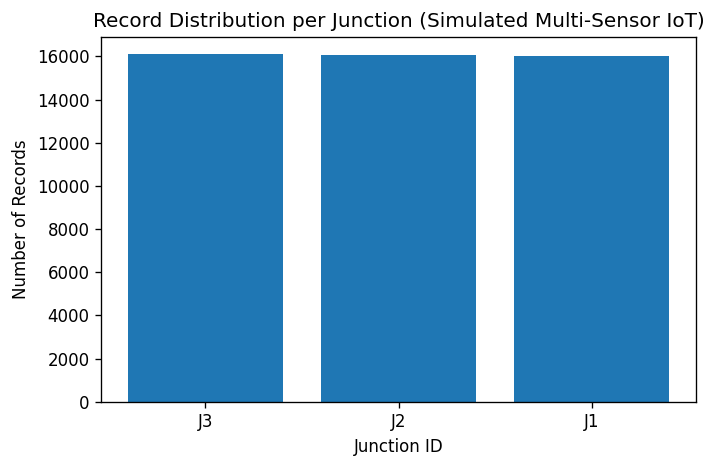

In [22]:
traffic_multi_df = traffic_df.copy()

junction_ids = ["J1", "J2", "J3"]
sensor_ids   = ["S1", "S2", "S3"]

traffic_multi_df["junction_id"] = np.random.choice(junction_ids, size=len(traffic_multi_df))
traffic_multi_df["sensor_id"]   = np.random.choice(sensor_ids,   size=len(traffic_multi_df))

print(traffic_multi_df[["timestamp", "junction_id", "sensor_id", "vehicle_count"]].head(10))

counts_per_junction = traffic_multi_df["junction_id"].value_counts()

plt.figure()
plt.bar(counts_per_junction.index, counts_per_junction.values)
plt.xlabel("Junction ID")
plt.ylabel("Number of Records")
plt.title("Record Distribution per Junction (Simulated Multi-Sensor IoT)")
plt.tight_layout()
plt.show()


In [23]:
export_dict = {}
for idx, entry in encrypted_store.items():
    export_dict[idx] = {
        "nonce": entry["nonce"].hex(),
        "ciphertext": entry["ciphertext"].hex()
    }

with open("encrypted_store.json", "w") as f:
    json.dump(export_dict, f)

print("Saved encrypted_store.json in the current directory.")



Saved encrypted_store.json in the current directory.


## Security & Privacy Analysis

- **Confidentiality:**  
  Real traffic records are encrypted using AES-256-GCM before storage. The symmetric key is
  never exposed in the pipeline, ensuring that any intercepted ciphertext remains unreadable.

- **Integrity & Tamper Resistance:**  
  For each encrypted payload, a SHA-256 hash is stored inside a blockchain-style ledger.
  Any modification to the off-chain ciphertext causes a hash mismatch, which is caught by
  `verify_block()`. The hash chain (`prev_hash`) makes historical tampering visible.

- **Access Control & Accountability:**  
  RBAC restricts decryption to entities with the `AUTHORITY` role. Unauthorized decryption
  attempts are logged in `access_log`, creating an audit trail for policy violations.

- **Performance Overhead:**  
  The secure pipeline (encryption + hashing + ledger append) is slower than plaintext storage,
  but measurements show that the overhead remains acceptable for smart traffic systems where
  reaction times are measured in seconds rather than microseconds.

- **Advanced Security:**  
  A simple Proof-of-Work demo illustrates how difficulty-based consensus can be added on top
  of the ledger if needed, increasing resistance against certain classes of attacks.
